In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import seaborn as sns
import glob
import pickle
from collections import defaultdict
from Bio.Seq import Seq

## Load GC trees

In [4]:
results = "../nextflow/results/latest"

In [10]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), f"{PR_str[3]}-{PR_str[2]}"

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    key = "_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file)))
    if not any(key.split("_")[0] == f"mouse{i}" for i in range(1, 7)):
        print(f"skipping {key}")
        continue
    assert key not in trees, key
    trees[key] = pickle.load(open(file, "rb"))

    
#     trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
#          for file in files}

print(f"loaded {len(trees)} GC trees")

skipping mouse7_GC90-RP
skipping mouse7_GC91-LP
skipping mouse7_GC92-RI
skipping mouse7_GC93-LI
skipping mouse8_GC84-RP
skipping mouse8_GC85-LP
skipping mouse8_GC86-RI
skipping mouse8_GC87-LI
skipping mouse8_GC88-RB
skipping mouse8_GC89-LB
skipping mouse11_GC111-RP
skipping mouse11_GC113-LP
skipping mouse11_GC114-LP
skipping mouse11_GC115-RB
skipping mouse11_GC117-RB
skipping mouse11_GC118-LB
skipping mouse11_GC119-LB
skipping mouse11_GC120-LB
skipping mouse11_GC121-LB
skipping mouse11_GC122-LA
skipping mouse12_GC123-RP
skipping mouse12_GC124-LP
skipping mouse12_GC125-RB
skipping mouse12_GC126-RB
skipping mouse12_GC127-RB
skipping mouse12_GC128-LB
skipping mouse12_GC129-LB
skipping mouse12_GC130-LA
loaded 67 GC trees


## 5mer mutability model

In [11]:
mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)

naive = next(iter(trees.values())).tree.sequence
igh_frame = 1
igk_frame = 1
igk_idx = 336

def mutate(sequence):
    sequence_H = "NN" + sequence[:igk_idx] + "NN"
    sequence_K = "NN" + sequence[igk_idx:] + "NN"
    # mutabilities of each nucleotide
    contexts = [sequence_H[(i - 2) : (i + 3)]
                    for i in range(2, len(sequence_H) - 2)
                   ] + [sequence_K[(i - 2) : (i + 3)]
                        for i in range(2, len(sequence_K) - 2)
                       ]
    mutabilities = np.array([mutability[context] for context in contexts])
    i = np.random.choice(len(mutabilities), p=mutabilities / sum(mutabilities))
    sequence = sequence[:i] + np.random.choice(substitution.columns, p=substitution.loc[contexts[i]].fillna(0)) + sequence[(i + 1):]
    return sequence

def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

def mutations(naive_aa, aa, pos_map, chain_annotation):
    return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
            for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
            if aa1 != aa2]

naive_igh_aa = aa(naive[:igk_idx], igh_frame)
naive_igk_aa = aa(naive[igk_idx:], igk_frame)

## DMS data

In [12]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-128


In [13]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [14]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

## Simulate expression-matched trees

This cell takes a while (~1 hour)

**NOTE: needs to be redone completely with TDMS model for simualtions!**

In [25]:
sim_trees = defaultdict(lambda: ([], []))
expression_threshold = 0.1 #np.inf
n_replicates = 1
for gc, tree in trees.items():
    print(f"GC {gc}")
    for expression_matching in (False,):#, True):
        replicate = 1
        dead = False
        while replicate <= n_replicates:
            print(f"  {'expression matched ' if expression_matching else ''}replicate {replicate}", end="   \r")
            new_tree = tree.tree.copy()
            for node, node_new in zip(tree.tree.traverse(strategy="preorder"), new_tree.traverse(strategy="preorder")):
                assert node.name == node_new.name
                if not node.is_root():
                    success = False
                    closest = np.inf
                    for tries in range(100):
                        node_new.sequence = node_new.up.sequence
                        for _ in range(int(node.dist)):
                            node_new.sequence = mutate(node_new.sequence)
                            igh_aa = aa(node_new.sequence[:igk_idx], igh_frame)
                            igk_aa = aa(node_new.sequence[igk_idx:], igk_frame)
                            igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
                            igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")        
                            all_mutations = igh_mutations + igk_mutations
                            if any("*" in x for x in all_mutations):
                                node_new.delta_bind_CGG_FMVS_additive = None
                                node_new.delta_expr_FMVS_additive = None
                                node_new.delta_psr_FMVS_additive = None
                            else:
                                node_new.delta_bind_CGG_FMVS_additive = np.nan #dms_df.delta_bind_CGG[all_mutations].sum()
                                node_new.delta_expr_FMVS_additive = np.nan #dms_df.delta_expr[all_mutations].sum()
                                node_new.delta_psr_FMVS_additive = np.nan #dms_df.delta_psr[all_mutations].sum()
                        # note: selecting on additive expression estimate
                        if node_new.delta_expr_FMVS_additive is None:
                            continue
                        delta = np.abs(node_new.delta_expr_FMVS_additive - node.delta_expr_FMVS_additive)
                        if delta < closest:
                            closest = delta
                            closest_seq = node_new.sequence
                            delta_bind_CGG = node_new.delta_bind_CGG_FMVS_additive
                            closest_delta_expr = node_new.delta_expr_FMVS_additive
                            closest_delta_psr = node_new.delta_psr_FMVS_additive
                        if not expression_matching or delta < expression_threshold:
                            success = True
                            break
                    if not success:
                        node_new.sequence = closest_seq
                        node_new.delta_bind_CGG_FMVS_additive = delta_bind_CGG
                        node_new.delta_expr_FMVS_additive = closest_delta_expr
                        node_new.delta_psr_FMVS_additive = closest_delta_psr

            sim_trees[gc][expression_matching].append(new_tree)
            replicate += 1
        print()

GC mouse1_GC1-RP
  replicate 1   
GC mouse1_GC11-RB
  replicate 1   
GC mouse1_GC12-RB
  replicate 1   
GC mouse1_GC13-RB
  replicate 1   
GC mouse1_GC14-RB
  replicate 1   
GC mouse1_GC15-RB
  replicate 1   
GC mouse1_GC16-LB
  replicate 1   
GC mouse1_GC17-LB
  replicate 1   
GC mouse1_GC18-LB
  replicate 1   
GC mouse1_GC19-LB
  replicate 1   
GC mouse1_GC2-RP
  replicate 1   
GC mouse1_GC20-LB
  replicate 1   
GC mouse1_GC3-RP
  replicate 1   
GC mouse1_GC4-LP
  replicate 1   
GC mouse1_GC5-LP
  replicate 1   
GC mouse1_GC6-LP
  replicate 1   
GC mouse1_GC7-RI
  replicate 1   
GC mouse2_GC21-RP
  replicate 1   
GC mouse2_GC22-RP
  replicate 1   
GC mouse2_GC23-RP
  replicate 1   
GC mouse2_GC24-LP
  replicate 1   
GC mouse2_GC25-LP
  replicate 1   
GC mouse2_GC26-LP
  replicate 1   
GC mouse2_GC28-RB
  replicate 1   
GC mouse2_GC29-RB
  replicate 1   
GC mouse2_GC30-RB
  replicate 1   
GC mouse2_GC31-RB
  replicate 1   
GC mouse2_GC32-LB
  replicate 1   
GC mouse2_GC34-LB
  replica

In [9]:
# sim_df = pd.DataFrame()
# replicate = 1
# delta_expr_threshold = -3
# fitness_transition = 10
# while replicate < 100:
#     print(f"replicate {replicate + 1}", end="   \r")
#     sequence = naive
#     n_mutations = 0
#     rep_df = pd.DataFrame()
#     dead = False
#     while n_mutations < 11:
#         if n_mutations:
#             new_sequence = mutate(sequence)
#         else:
#             new_sequence = sequence
# #         igh_aa = aa(new_sequence[:igk_idx], igh_frame)
# #         igk_aa = aa(new_sequence[igk_idx:], igk_frame)
# #         igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
# #         igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")
# #         all_mutations = igh_mutations + igk_mutations
#         all_mutations = igh_mutations + igk_mutations
#         tdms_prediction = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(new_sequence))).detach() - tdms_prediction_naive
#         if np.random.rand() < expit(-fitness_transition * (tdms_prediction[1] - delta_expr_threshold)):
#             dead=True
#             break
#         sequence = new_sequence
#         new_row = pd.Series({"delta_bind_CGG": tdms_prediction[0].item(),
#                              "delta_expr": tdms_prediction[1].item(),
#                              "n_mutations": n_mutations,
#                              "replicate": replicate})
#         rep_df = rep_df.append(new_row, ignore_index=True, verify_integrity=True)
#         n_mutations += 1
#     if not dead:
#         sim_df = sim_df.append(rep_df, ignore_index=True, verify_integrity=True)
#         replicate += 1
# sim_df

In [26]:
output_dir = "output/phenotype-trajectories"

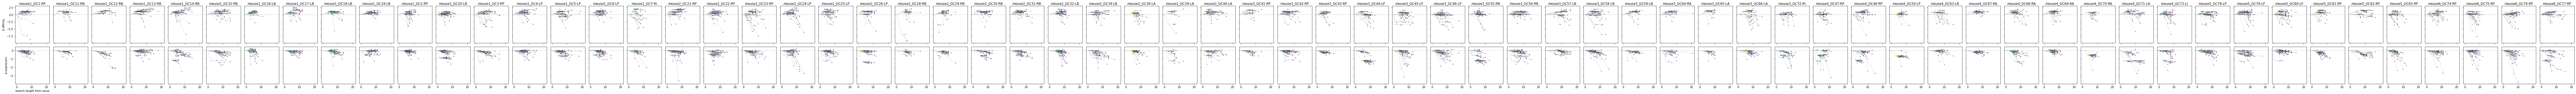

In [27]:
# fig, axes = plt.subplots(3, len(trees), figsize=(1.5 * len(trees), 6), sharex=True, sharey="row")
# note: skipping psr and some GCs
fig, axes = plt.subplots(2, len(trees), figsize=(2 * len(trees), 5), sharex=True, sharey="row")

vmin_log10LBI = 0
vmax_log10LBI = 1.5

for i, (phenotype, phenotype_label) in enumerate(zip(("delta_bind_CGG_FMVS_additive", "delta_expr_FMVS_additive"
                                                      ),
                                                     (r"$\Delta$ affinity", r"$\Delta$ expression"
                                                      )
                                                     )):
    for j, (gc, tree) in enumerate(trees.items()):
        points = []
        lines = []
        colors = []
        
#         if j == 4: break
        
        for node in tree.tree.traverse():
            log10_LBI = np.log10(node.LBI)
            points.append((tree.tree.get_distance(node),
                           getattr(node, phenotype),
                           1 + 5 * node.abundance,
                           log10_LBI))
            if node.up is not None:
                lines.append([(tree.tree.get_distance(node.up), getattr(node.up, phenotype)),
                              (tree.tree.get_distance(node), getattr(node, phenotype))])
            colors.append(log10_LBI)

        sim_lines = []
        for sim_idx, sim_tree in enumerate(sim_trees[gc][0]):
            for node in sim_tree.traverse():
                if node.up is not None:
                    sim_lines.append([(sim_tree.get_distance(node.up), getattr(node.up, phenotype)),
                                      (sim_tree.get_distance(node), getattr(node, phenotype))])
        sim_lines_matched = []
        for sim_idx, sim_tree in enumerate(sim_trees[gc][1]):
            for node in sim_tree.traverse():
                if node.up is not None:
                    sim_lines_matched.append([(sim_tree.get_distance(node.up), getattr(node.up, phenotype)),
                                              (sim_tree.get_distance(node), getattr(node, phenotype))])
        lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
        sim_lc = mc.LineCollection(sim_lines, colors="C0", linewidths=1, alpha=0.1, zorder=2)
        sim_matched_lc = mc.LineCollection(sim_lines_matched, colors="C1", linewidths=1, alpha=0.1, zorder=2)

        ax = axes[i, j]
        ax.axhline(0, c="k", ls="--", lw=0.25, zorder=1)
#         if phenotype == "delta_expr":
#             ax.axhline(delta_expr_threshold, c="r", ls="--", lw=0.25, zorder=1)
        ax.add_collection(lc)
        ax.add_collection(sim_lc)
        ax.add_collection(sim_matched_lc)
        ax.scatter(*zip(*points), cmap="viridis", vmin=vmin_log10LBI, vmax=vmax_log10LBI, alpha=0.8, edgecolors="k", linewidths=0.2, zorder=4)
        if i == 0:
            ax.set_title(gc)
        ax.set_xlabel(None)
#         break
    axes[i, 0].set_ylabel(phenotype_label)
axes[-1, 0].set_xlabel("branch length from naive")
plt.tight_layout()
plt.savefig(f"{output_dir}/phenotype-trajectories.pdf")
plt.show()

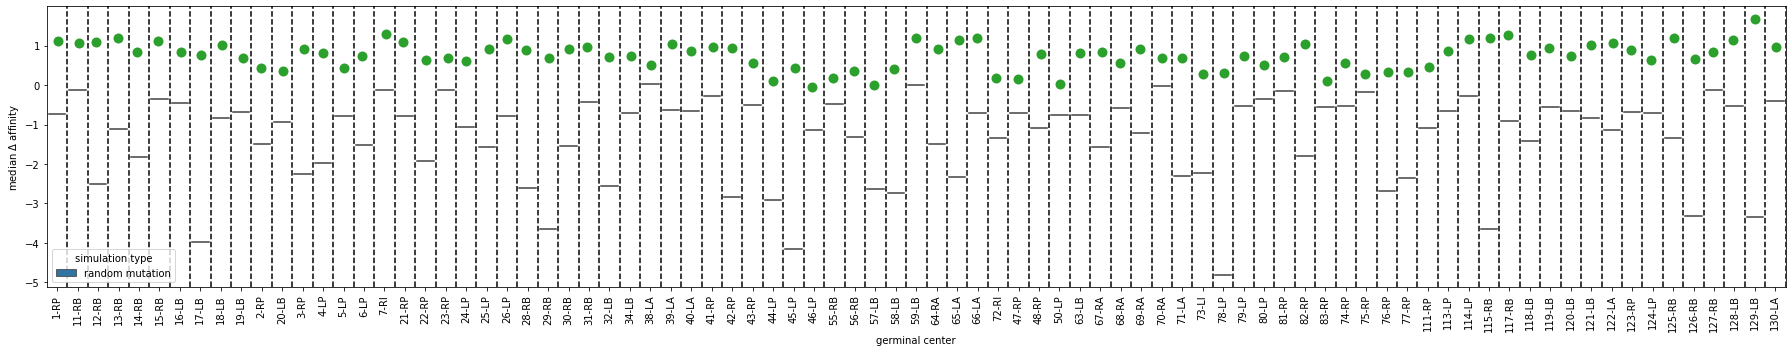

In [41]:
def tree_stats(tree):
    affinity_dat = []
    expression_dat = []
    cells_sampled = 0
    for node in tree.traverse():
        cells_sampled += node.abundance
        for _ in range(node.abundance):
            affinity_dat.append(node.delta_bind_FMVS_additive)
            expression_dat.append(node.delta_stab_FMVS_additive)
    return cells_sampled, np.nanmedian(affinity_dat), np.nanmedian(expression_dat)

dat = []
for mousegc, tree in trees.items():
    mouse, gc = mousegc.split("_")
    mouse = mouse.lstrip("mouse")
    gc = gc.lstrip("GC")
    dat.append([mouse, gc, False, None, *tree_stats(tree.tree)])
    for rep_tree in sim_trees[mousegc][0]:
        dat.append([mouse, gc, True, "random mutation", *tree_stats(rep_tree)])
    for rep_tree in sim_trees[mousegc][1]:
        dat.append([mouse, gc, True, "expression matched", *tree_stats(rep_tree)])

stat_df = pd.DataFrame(dat, columns=["mouse", "germinal center", "simulation", "simulation type", "cells sampled", r"median $\Delta$ affinity", r"median $\Delta$ expression"])    

plt.figure(figsize=(25, 5))
g = sns.violinplot(data=stat_df.loc[stat_df.simulation == True],
                x="germinal center", y=r"median $\Delta$ affinity", hue="simulation type",
                # split=True,
                # dodge=False
                   split=True, inner="stick"
               )
sns.stripplot(data=stat_df.loc[stat_df.simulation == False],
              x="germinal center", y=r"median $\Delta$ affinity",
              color="C2", size=10)
for item in g.get_xticklabels():
    item.set_rotation(90)
for tick_pos in g.get_xticks():
    plt.axvline(tick_pos + 0.5, c="k", ls="--")
plt.tight_layout()
plt.savefig(f"{plot_dir}/phenotype-trajectories.summary.pdf")
plt.show()

# sns.displot(data=stat_df, col="GC", x=fr"GC fraction with $\Delta\log_{{10}}K_a>{threshold}$", hue="simulation type", col_wrap=4)
# sns.displot(data=stat_df.loc[stat_df.simulation == False], col="GC", x=fr"GC fraction with $\Delta\log_{{10}}K_a>{threshold}$", hue="simulation type", col_wrap=4, rug=True)
# # plt.savefig(f"{plot_dir}/selection_stat.pdf")
# plt.show()

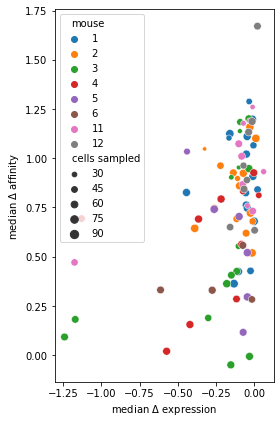

In [42]:
plt.figure(figsize=(4, 6))
sns.scatterplot(data=stat_df.loc[stat_df.simulation == False],
                x=r"median $\Delta$ expression", y=r"median $\Delta$ affinity", hue="mouse",
                size="cells sampled")
# sns.kdeplot(data=stat_df.loc[stat_df.simulation == True],
#                 x=r"median $\Delta$ expression", y=r"median $\Delta$ affinity", hue="simulation type", weights="cells sampled")
plt.tight_layout()
plt.show()

In [44]:
dat = []
for mousegc, tree in trees.items():
    mouse, gc = mousegc.split("_")
    mouse = mouse.lstrip("mouse")
    gc = gc.lstrip("GC")
    
    clade_sizes = [sum(node.abundance for node in child.traverse()) for child in tree.tree.children]
    dom_score = max(clade_sizes) / sum(clade_sizes)
    max_LBR = np.nanmax([node.LBR for node in tree.tree.traverse()])
    
    for node in tree.tree.traverse():
        if node.abundance:
            dat.append([mouse, gc, node.name, node.abundance, tree.tree.get_distance(node), node.delta_bind_FMVS_additive, node.delta_stab_FMVS_additive])

cell_df = pd.DataFrame(dat, columns=("mouse", "germinal center", "id", "cells sampled", "divergence from naive BCR", r"$\Delta$ affinity", r"$\Delta$ expression"))

cell_df

,mouse,germinal center,id,cells sampled,divergence from naive BCR,$\Delta$ affinity,$\Delta$ expression
0,1,1-RP,seq37,1,4.0,-0.06082,0.14827
1,1,1-RP,seq47,1,11.0,-3.45668,-1.05627
2,1,1-RP,seq56,1,1.0,-0.80796,-0.15104
3,1,1-RP,seq26,1,3.0,-1.52301,-0.34882
4,1,1-RP,seq57,1,9.0,-9.09012,-0.81985
...,...,...,...,...,...,...,...
5524,12,130-LA,seq32,1,6.0,NaN,NaN
5525,12,130-LA,seq4,1,6.0,1.21465,-0.30891
5526,12,130-LA,seq57,1,7.0,0.93495,0.03260
5527,12,130-LA,seq5,1,8.0,1.27661,-0.11842


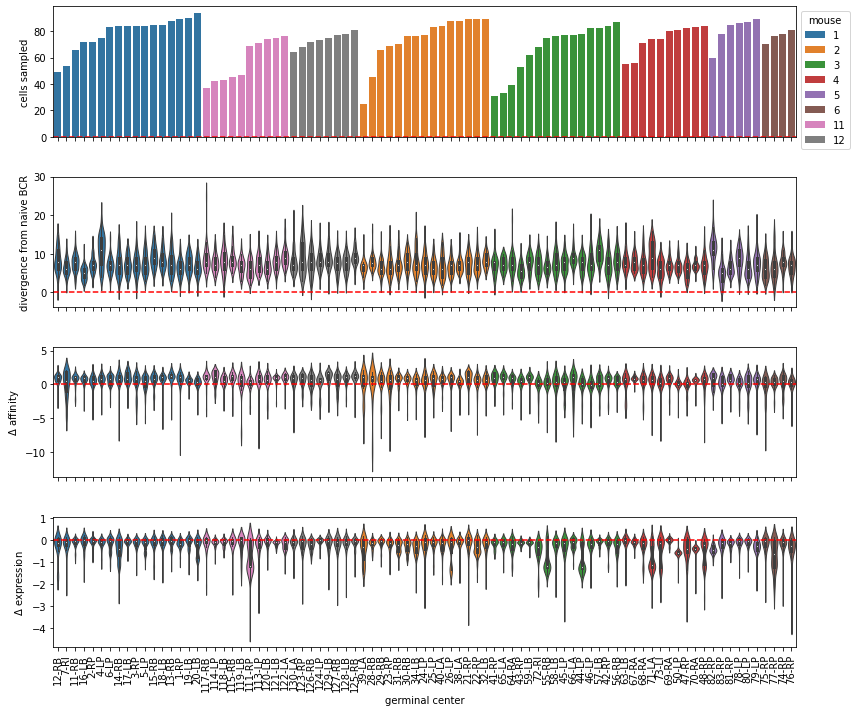

In [50]:
order = cell_df.groupby("germinal center").agg({"mouse": "first", "cells sampled": sum}).sort_values(["mouse", "cells sampled"]).index

fig, axes = plt.subplots(4, 1, sharex="col", figsize=(12, 10))

sns.barplot(data=cell_df, x="germinal center", hue="mouse", y="cells sampled", order=order,
            ci=None, estimator=sum, dodge=False, ax=axes[0])
sns.move_legend(axes[0], "upper left")
axes[0].set(xlabel=None)
axes[0].axhline(0, ls="--", c="red")

ax = sns.violinplot(data=cell_df, x="germinal center", hue="mouse", y="divergence from naive BCR", weights="abundance", order=order,
                    dodge=False, legend=False, linewidth=1, ax=axes[1])
axes[1].get_legend().remove()
axes[1].set(xlabel=None)
axes[1].axhline(0, ls="--", c="red")

ax = sns.violinplot(data=cell_df, x="germinal center", hue="mouse", y=r"$\Delta$ affinity", weights="abundance", order=order,
                    dodge=False, legend=False, linewidth=1, ax=axes[2])
axes[2].get_legend().remove()
axes[2].set(xlabel=None)
axes[2].axhline(0, ls="--", c="red")

ax = sns.violinplot(data=cell_df, x="germinal center", hue="mouse", y=r"$\Delta$ expression", weights="abundance", order=order,
                    dodge=False, legend=False, linewidth=1, ax=axes[3])
axes[3].get_legend().remove()
axes[3].axhline(0, ls="--", c="red")

sns.move_legend(axes[0], "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(f"{plot_dir}/phenotype-trajectories.cell-summary.pdf")
plt.show()